In [1]:
%matplotlib notebook
%matplotlib notebook

# load GB ANN libraries
import os
os.sys.path.append('../src')

import utils as ut
import chemostat_model as gb_ann
import custom_layers as cl

# Dependencies
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import scipy.stats as sps
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


# Grey box packages

# Plotting options
sns.set_style('ticks')
cm = plt.get_cmap("viridis")
sns.set_context('paper')
np.random.seed(seed=20)
blue = sns.color_palette()[0]
green = sns.color_palette()[1]
red = sns.color_palette()[2]
yellow = sns.color_palette()[4]

# Enable eager for interactive tensorflow session
tf.enable_eager_execution()

# Seed for reproduceability
np.random.seed(1234)

In [2]:
CGlcIn = 20
D      = .05
YGlcX   = .435        # GRAM CELL / GRAM GLUCOSE
YGlcEtOH  = .607     # GRAM EtOH / GRAM GLUCOSE
YGlcIBA = .3        # GRAM IBA/ GRAM GLUCOSE 
# PARAMS FOR CELL GROWTH
MU0     = 3.659e-3*60 # 1 / HOUR
Ks      = 1.03        # GRAM / LITER
KEtOH   = 7.12        # GRAM / LITER
KIBA    = 0.712       # GRAM / LITER

KMU0IBA = .5
# PARAMS FOR EtOH PRODUCTION
MU0ETOHMAX   = 1.790    # 1 / HOUR
MU0ETOHMIN = 0
MU0ETOHDELTA = MU0ETOHMAX-MU0ETOHMIN;
KsEtOH    = 1.68     # GRAM / LITER
KEtOHEtOH = 14       # GRAM / LITER

TAU_ETOH = 5         # HOUR
TAU_ETOHRNA = 1      # HOUR
N_ETOH = 2.7165
KH_ETOH = .0799

# PARAMS FOR IBA PRODUCTION
MU0IBAMAX  = 1.790/4     # 1 / HOUR
MU0IBAMIN  = .2*MU0IBAMAX
MU0IBADELTA = MU0IBAMAX-MU0IBAMIN;
KsIBA   = 1.68      # GRAM / LITER
KIBAIBA = 14        # GRAM / LITER

TAU_IBA = 6         # HOUR
TAU_IBARNA = 1      # HOUR
N_IBA = 2.3047
KH_IBA = 0.3029
def ode(t,U,light_fun):
    
    
    light  = light_fun(t)
            
    Cx         = U[0]
    CGlc       = U[1]
    CEtOH      = U[2]
    CIBA       = U[3]
    MU0ETOH    = U[4]
    MU0IBA     = U[5]
    MU0ETOHRNA = U[6]
    MU0IBARNA  = U[7]
    BIOSENSOR  = U[8]





    MU= MU0 * CGlc * np.exp(-CEtOH/KEtOH - CIBA/KIBA - MU0IBA/KMU0IBA) / (Ks + CGlc)
    MUEtOH = MU0ETOH * CGlc * np.exp(-CEtOH/KEtOHEtOH) / (KsEtOH + CGlc)
    MUIBA = MU0IBA * CGlc * np.exp(-CIBA/KIBAIBA) / (KsIBA + CGlc)
    F = np.zeros(9)
    F[0] = (MU - D)*Cx
    GLUCOSE_CONSUMPTION = (-MU/YGlcX - MUEtOH/YGlcEtOH - MUIBA/YGlcIBA)*Cx
    F[1] = GLUCOSE_CONSUMPTION + (CGlcIn - CGlc)*D
    F[2] = MUEtOH*Cx - D*CEtOH
    F[3] = MUIBA*Cx - D*CIBA

    MU0ETOH_STEADY  = MU0ETOHDELTA * light**N_ETOH/(KH_ETOH**N_ETOH+ light**N_ETOH) + MU0ETOHMIN
    MU0IBA_STEADY = MU0IBADELTA * (1-light)**N_IBA/(KH_IBA**N_IBA +(1-light)**N_IBA) + MU0IBAMIN

    if light >= 1:
        MU0IBA_steady = MU0IBAMIN
    elif light <= 0:
        MU0ETOH_steady = MU0ETOHMIN
    
    F[4] = -1/TAU_ETOH*(MU0ETOH - MU0ETOHRNA)
    F[5] = -1/TAU_IBA*(MU0IBA - MU0IBARNA)
    F[6] = -1/TAU_ETOHRNA * (MU0ETOHRNA - MU0ETOH_STEADY)
    F[7] = -1/TAU_IBARNA * (MU0IBARNA - MU0IBA_STEADY)
    F[8] = 2*np.sqrt(MU0IBA) - BIOSENSOR/2
    
    return F

In [3]:
simulation_time = 24*80                           # simulate a 4 week experiment
switch_time = 24                                  # in hours, for control switches
measure_time = 16                                 # sample time for off-line measurements
sample_time = 1                                   # sample time for on-line measurements
N_switches = int(simulation_time/switch_time)+1     # number of controls
N_online_steps= int(simulation_time/sample_time)+1  # number of online measurements betweens steps
N_measurements = int(simulation_time/measure_time)+1# number of off-line measurements

t_sim = np.linspace(0,simulation_time,N_online_steps)
t_measure = np.linspace(0,simulation_time,N_measurements)


light_steps = np.random.uniform(0,1,size=(N_switches+1,1)) # add an extra light step to pad the end
#def light_fun(t):
#    try:
#        return light_steps[int(np.floor(t/switch_time))]
#    except:
#        print('time failed at:', t)
#        return .5

#switch_times = np.cumsum(np.random.exponential(10,simulation_time*2))
#N_switches = len(switch_times)
#light_steps = np.random.uniform(0,1,size=(N_switches,1))
def light_fun(t):
    try:
        if t < 24*4:
            if t<48:
                return 1
            else:
                return 0
        else:
            #return light_steps[t<switch_times][0]
            return light_steps[int(np.floor(t/switch_time))]
    except:
        print('time failed at:', t)
        return .5
lights = np.zeros(N_online_steps)
for i in range(len(t_sim)):
    lights[i] = light_fun(t_sim[i])

    
    
#t_switch = np.linspace(0,simulation_time,N_switches)


# online outputs: Density, MU0IBA
y_on = np.zeros((N_online_steps,2))

# All states full time series
x_on = np.zeros((N_online_steps,9))

# All states full time series
u_on = np.zeros((N_online_steps,1))

phi_on = np.zeros((N_online_steps,6))


In [4]:
x0 = np.array([1.635e-1,
               5.159, 
               2.170,
               2.668e-1,
               1.666,
               9.883e-2,
               1.7881,
               8.85e-2,
               0 ])

# initialize at 50% light
t_init = np.linspace(0,200,20)
x,infodict = spi.odeint(lambda x,t : ode(t,x,lambda t:.5), x0,t_init,full_output=True)
x0 = x[-1]

integrator = spi.ode(lambda t,x : ode(t,x,light_fun))
integrator.set_initial_value(x0)
integrator.set_integrator('vode')

for i in range(N_online_steps):
    if i > 0:
        integrator.integrate(t_sim[i])

    #print(integrator.y)
    u_on[i] = light_fun(t_sim[i])
    noise = np.random.normal(0,1,9)
    noise = noise*(.02*x_on[i-1])*0
    x_on[i] = integrator.y+noise
    y_on[i] = np.array([x_on[i,0],x_on[i,0]*x_on[i,8]])
    

    
    phi_on[i,0] = MU0 * integrator.y[1] * np.exp(-integrator.y[2]/KEtOH - integrator.y[3]/KIBA - integrator.y[5]/KMU0IBA) / (Ks + integrator.y[1])
    phi_on[i,1] = integrator.y[4] * integrator.y[1] * np.exp(-integrator.y[2]/KEtOHEtOH) / (KsEtOH + integrator.y[1])
    phi_on[i,2] = integrator.y[5] * integrator.y[1] * np.exp(-integrator.y[3]/KIBAIBA) / (KsIBA + integrator.y[1])
    phi_on[i,3] = YGlcX
    phi_on[i,4] = YGlcEtOH
    phi_on[i,5] = YGlcIBA



<IPython.core.display.Javascript object>


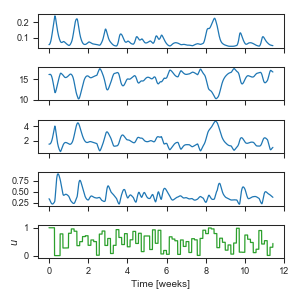

In [5]:
sns.set_context('paper')
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, sharex=True, figsize=(4,4))
ax1.plot(t_sim/24/7,x_on.T[0])

plt.ylabel(r'$X$')
#plt.legend(['Cell Density', 'Biosensor'],frameon=True, loc='upper right')

plt.ylabel(r'$Glc$')
ax2.plot(t_sim/24/7,x_on.T[1])

plt.ylabel(r'$EtOH$')
ax3.plot(t_sim/24/7,x_on.T[2])

plt.ylabel(r'$IBA$')
ax4.plot(t_sim/24/7,x_on.T[3])
plt.xlabel('Time [weeks]')

#plt.ylim(-3.5,3.5)

ax5.plot(t_sim/24/7,u_on,c=red)
plt.ylabel(r'$u$')
plt.ylim(-.1,1.1)


plt.tight_layout()

#plt.savefig('../fig/training_chemostat.svg')

<IPython.core.display.Javascript object>


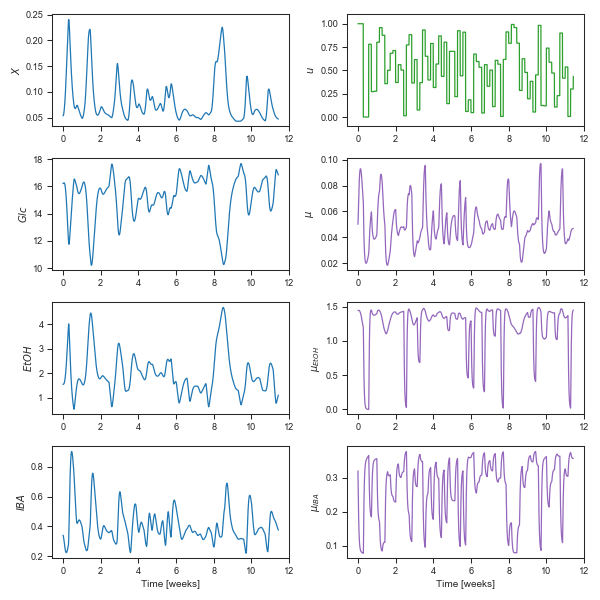

In [6]:
sns.set_context('paper')
plt.figure(figsize=(8,8))
plt.subplot(421)
plt.plot(t_sim/24/7,x_on.T[0])

plt.ylabel(r'$X$')
#plt.legend(['Cell Density', 'Biosensor'],frameon=True, loc='upper right')
plt.subplot(423)
plt.ylabel(r'$Glc$')
plt.plot(t_sim/24/7,x_on.T[1])
plt.subplot(425)
plt.ylabel(r'$EtOH$')
plt.plot(t_sim/24/7,x_on.T[2])
plt.subplot(427)
plt.ylabel(r'$IBA$')
plt.plot(t_sim/24/7,x_on.T[3])
plt.xlabel('Time [weeks]')

#plt.ylim(-3.5,3.5)
plt.subplot(422)
plt.plot(t_sim/24/7,u_on,c=red)
plt.ylabel(r'$u$')
plt.ylim(-.1,1.1)


plt.subplot(424)
plt.plot(t_sim/24/7,phi_on.T[0],c=yellow)
plt.ylabel(r'$\mu$')
#plt.ylim(.0,0.10)

plt.subplot(426)
plt.plot(t_sim/24/7,phi_on.T[1],c=yellow)
plt.ylabel(r'$\mu_{EtOH}$')
#plt.ylim(0,2.1)

plt.subplot(428)
plt.plot(t_sim/24/7,phi_on.T[2],c=yellow)
plt.ylabel(r'$\mu_{IBA}$')
plt.xlabel('Time [weeks]')
#plt.ylim(-.1,0.6)



plt.tight_layout()

#plt.savefig('../fig/training_chemostat.svg')

In [7]:
# collect data in format for GB-ANN model
n_var = 5 # 5 variables (X, GLC, EtOH, IBA, light) in the model
x_k = x_on[:,[0,1,2,3]].reshape(N_online_steps,4) # x_k = [X, GLC, EtOH, IBA][k]
u_k = u_on.reshape(N_online_steps,1)      # u_k = light[k]
z_k = np.hstack([u_k,x_k])                # z_k = [u_k,x_k]
phi_k = phi_on  # the (to be learned) rate and yield coefficients

mean_x   = np.mean(x_k,axis=0)
s_x      = np.std(x_k,axis=0)
mean_u   = np.mean(u_k)
s_u      = np.std(u_k)
mean_z   = np.append(mean_u, mean_x)
s_z      = np.append(s_u, s_x)
# Use 0,1 for mean,std of yield constants
mean_phi = np.mean(phi_k[:,0:3],axis=0) # could use estimate here in absense of underlying data
s_phi    = np.std(phi_k[:,0:3],axis=0) 

# standardize the data
xs_k = (x_k - mean_x)/s_x
us_k = (u_k - mean_u)/s_u
zs_k = np.hstack([us_k,xs_k])
# embed the data
lag = 1
embed = 51

# for simple notation, use ze_k for standardized embedded z (don't need unstandardized form)
ze_k = ut.embed_data(zs_k,lag,embed)
points = np.arange((embed-1)*lag,N_online_steps)

# save sample time tensor
sample_time_tensor = sample_time*tf.ones([len(points),1])

# discard data before enough collected for embedding
xfs_k = xs_k
ufs_k = us_k
xs_k = xs_k[points]
us_k = us_k[points]
zs_k = zs_k[points]

lag_in_model = 5

In [44]:
np.max(xfs_k)

4.254890837719046

<IPython.core.display.Javascript object>


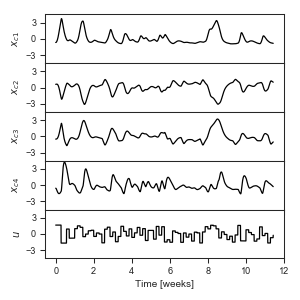

In [8]:
sns.set_context('paper')
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, sharex=True, sharey=True,figsize=(4,4))
ax1.plot(t_sim/24/7,xfs_k.T[0],c='k')
ax1.set_ylim(-4.5,4.5)
ax1.set_yticks([-3,0,3])
ax1.set_ylabel(r'$x_{c1}$')

#plt.legend(['Cell Density', 'Biosensor'],frameon=True, loc='upper right')

ax2.plot(t_sim/24/7,xfs_k.T[1],c='k')
ax2.set_ylim(-4.5,4.5)
ax2.set_yticks([-3,0,3])
ax2.set_ylabel(r'$x_{c2}$')

plt.ylabel(r'$EtOH$')
ax3.plot(t_sim/24/7,xfs_k.T[2],c='k')
ax3.set_ylim(-4.5,4.5)
ax3.set_yticks([-3,0,3])
ax3.set_ylabel(r'$x_{c3}$')

plt.ylabel(r'$IBA$')
ax4.plot(t_sim/24/7,xfs_k.T[3],c='k')
ax4.set_ylim(-4.5,4.5)
ax4.set_yticks([-3,0,3])
ax4.set_ylabel(r'$x_{c4}$')

#plt.ylim(-3.5,3.5)

ax5.plot(t_sim/24/7,ufs_k,c='k')
ax5.set_ylim(-4.5,4.5)
ax5.set_yticks([-3,0,3])
ax5.set_ylabel(r'$u$')
ax5.set_xlabel('Time [weeks]')




plt.tight_layout()
fig.subplots_adjust(hspace=0)
#plt.savefig('../figs/training_data_chemostat.svg')

<IPython.core.display.Javascript object>


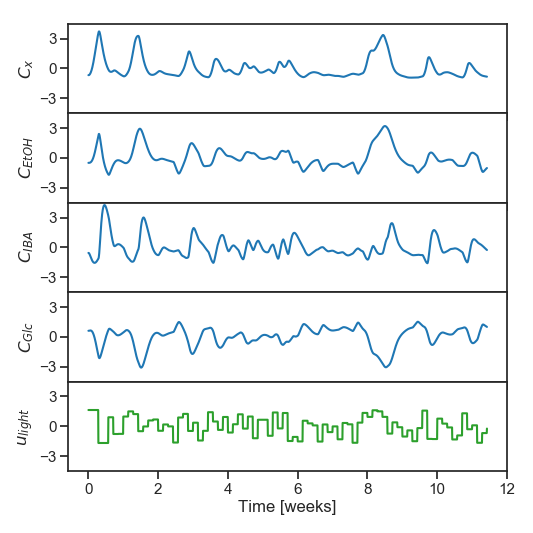

In [322]:
sns.set_context('talk')
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, sharex=True, sharey=True,figsize=(8,8))
ax1.plot(t_sim/24/7,xfs_k.T[0],c=blue)
ax1.set_ylim(-4.5,4.5)
ax1.set_yticks([-3,0,3])
ax1.set_ylabel(r'$C_x$')

#plt.legend(['Cell Density', 'Biosensor'],frameon=True, loc='upper right')

ax4.plot(t_sim/24/7,xfs_k.T[1],c=blue)
ax4.set_ylim(-4.5,4.5)
ax4.set_yticks([-3,0,3])
ax4.set_ylabel(r'$C_{Glc}$')

plt.ylabel(r'$EtOH$')
ax2.plot(t_sim/24/7,xfs_k.T[2],c=blue)
ax2.set_ylim(-4.5,4.5)
ax2.set_yticks([-3,0,3])
ax2.set_ylabel(r'$C_{EtOH}$')

plt.ylabel(r'$IBA$')
ax3.plot(t_sim/24/7,xfs_k.T[3],c=blue)
ax3.set_ylim(-4.5,4.5)
ax3.set_yticks([-3,0,3])
ax3.set_ylabel(r'$C_{IBA}$')

#plt.ylim(-3.5,3.5)

ax5.plot(t_sim/24/7,ufs_k,c=red)
ax5.set_ylim(-4.5,4.5)
ax5.set_yticks([-3,0,3])
ax5.set_ylabel(r'$u_{light}$')
ax5.set_xlabel('Time [weeks]')




plt.tight_layout()
fig.subplots_adjust(hspace=0)
#plt.savefig('../figs/training_data_chemostat_talk.svg')

<IPython.core.display.Javascript object>


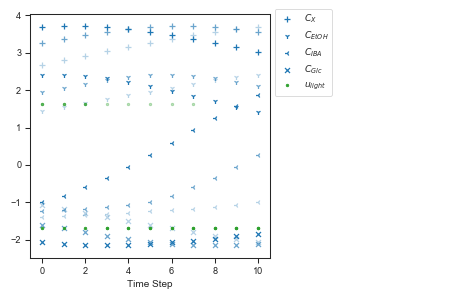

In [9]:
fig = plt.figure(figsize=(4*1.5,4))
ax = fig.add_subplot(111)

ax.scatter(t_sim[0:11], ze_k[0:11,1],color=blue, marker='+',label=r'$C_{X}$')
ax.scatter(t_sim[0:11], ze_k[0:11,1+5*5],color=blue, marker='+',alpha=.66)
ax.scatter(t_sim[0:11], ze_k[0:11,1+5*5*2],color=blue, alpha=0.33,marker='+')

ax.scatter(t_sim[0:11], ze_k[0:11,3],color=blue, marker='1',label=r'$C_{EtOH}$')
ax.scatter(t_sim[0:11], ze_k[0:11,3+5*5],color=blue, marker='1',alpha=.66)
ax.scatter(t_sim[0:11], ze_k[0:11,3+5*5*2],color=blue, alpha=.33,marker='1')


ax.scatter(t_sim[0:11], ze_k[0:11,4],color=blue, marker='3',label=r'$C_{IBA}$')
ax.scatter(t_sim[0:11], ze_k[0:11,4+5*5],color=blue, marker='3',alpha=.66)
ax.scatter(t_sim[0:11], ze_k[0:11,4+5*5*2],color=blue,alpha=0.33, marker='3')

ax.scatter(t_sim[0:11], ze_k[0:11,2],color=blue, marker='x',label=r'$C_{Glc}$')
ax.scatter(t_sim[0:11], ze_k[0:11,2+5*5],color=blue, marker='x',alpha=.66)
ax.scatter(t_sim[0:11], ze_k[0:11,2+5*5*2],color=blue,alpha=.33, marker='x')

ax.scatter(t_sim[0:11], ze_k[0:11,0],color=red, marker='.',label=r'$u_{light}$')
ax.scatter(t_sim[0:11], ze_k[0:11,0+5*5],color=red, marker='.',alpha=.66)
ax.scatter(t_sim[0:11], ze_k[0:11,0+5*5*2],color=red, alpha=.33, marker='.')

ax.set_xlabel('Time Step')
plt.tight_layout()
fig.subplots_adjust(right=.6)

plt.legend(bbox_to_anchor=(1, 1.042))
#plt.savefig('build_delay3.svg')

In [10]:
# compare with black box model

bb_in = tf.keras.Input(shape=(embed*n_var,))
selector = cl.column_selector_layer(lag_in_model,embed,n_var)
selected = selector(bb_in)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(selected)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
bb_next = tf.keras.layers.Dense(4)(h)


In [ ]:
# Test effect of training size
ERRORS = np.zeros((4,4,20)) # dims are model type/error type, n_train, and repeats
training_points = np.array([100,500,1000,1500])
for j in range(len(training_points)):
    N_train = training_points[j]
    print(N_train)

    k=0
    while k<20:
        ze_k_train = tf.to_float(ze_k[0:N_train])
        x_train    = tf.to_float(xs_k[1:N_train+1])
        st_train   = sample_time_tensor[0:N_train]

        ze_k_valid = tf.to_float(ze_k[N_train:-1])
        x_valid    = tf.to_float(xs_k[N_train+1::])
        st_valid   = sample_time_tensor[N_train:-1]

        
        #delete before retraining
        try:
            del Balance_Model
        except:
            pass
        Balance_Model = gb_ann.chemostat_GB_ANN(D,CGlcIn,mean_z,s_z,mean_phi,s_phi,lag_in_model,embed)
        ft =  Balance_Model.fit([ze_k_train,st_train],x_train,
                                batch_size=50,
                                epochs=100,
                                verbose=0,
                                #validation_data=([ze_k_valid,st_valid], x_valid)
                                )
        #pd.DataFrame(ft.history).plot()
        # delete before retraining
        try:
            del BlackBox
        except:
            pass 
        BlackBox = tf.keras.Model(inputs=bb_in,outputs=bb_next)
        BlackBox.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),loss=tf.losses.mean_squared_error)
        ft_bb =  BlackBox.fit(ze_k_train,x_train,
                                batch_size=int(N_train/10),
                                epochs=100,
                                verbose=0,
                                #validation_data = (ze_k_valid, x_valid)
                                )
        #pd.DataFrame(ft_bb.history).plot() 
        # Integrate the Model

        history0 = tf.reshape(tf.to_float(ze_k[0,n_var::]),[1,embed*n_var-n_var])
        xk0      = tf.reshape(tf.to_float(xs_k[0]),[1,4])
        uk0      = tf.reshape(tf.to_float(us_k[0]),[1,1])

        xkmodel = np.zeros([len(points),4])
        history = np.zeros([len(points),embed*n_var-n_var])
        xkmodel[0,:] = xk0
        history[0,:] = history0

        xkbbmodel = xkmodel.copy()
        historybb = history.copy()
        for i in range(len(points)):
            if i > 0:
                (xkmodel[i,:], history[i,:]) = Balance_Model.step(us_k[i-1],xkmodel[i-1],history[i-1])
                zek_bb = tf.reshape(tf.concat([tf.to_float(us_k[i-1]),
                                   tf.to_float(xkbbmodel[i-1]),
                                   tf.to_float(historybb[i-1])],axis=0),[1,n_var*embed])
                xkbbmodel[i,:] = BlackBox(zek_bb)
                historybb[i] = zek_bb[:,0:embed*n_var-n_var]
        phi_model = Balance_Model.constitutive_law(us_k,xkmodel,history)
        
        ERRORS[0,j,k] = Balance_Model.chemostat_GB_ANN_model.evaluate([ze_k_valid,st_valid], x_valid,verbose=False)
        ERRORS[1,j,k] = BlackBox.evaluate(ze_k_valid,x_valid,verbose=False)
        ERRORS[2,j,k] = np.mean((xkmodel[N_train::]-xs_k[N_train::])**2)
        ERRORS[3,j,k] = np.mean((xkbbmodel[N_train::]-xs_k[N_train::])**2)
        print(ERRORS[:,j,k])
        if any(ERRORS.flatten()>10) or any(np.isnan(ERRORS.flatten())):
            k -=1
            print('outlier control')
        k+=1
        

100
[0.0039122  0.71650199 1.05072692 0.85651443]
[0.00435237 0.7848695  1.95114119 0.87303134]
[4.44628666e-03 7.39019794e-01 7.32987163e+00 8.55569142e-01]
[3.52885776e-03 7.60270365e-01 7.55891328e+00 8.69368242e-01]
[5.08160631e-03 7.37042060e-01 7.80263759e+00 8.59235340e-01]
[4.74002493e-03 6.94271779e-01 5.10809819e+00 8.20798485e-01]
[6.50697773e-03 6.80546579e-01 7.27600180e+00 8.11030511e-01]
[4.08596751e-03 6.86053308e-01 7.50352199e+00 8.06738986e-01]
[2.77732720e-03 7.00363857e-01 5.08470424e+00 8.05438041e-01]
[3.79086857e-03 6.91874078e-01 7.11343855e+00 7.99151431e-01]


In [ ]:

MSE_MEAN = np.median(ERRORS,axis=2).T
MSE_STD = np.std(ERRORS,axis=2).T#std dev


In [ ]:
MSE_MEAN
MSE_STD


In [ ]:

sns.set_context('paper')
eval_data = pd.DataFrame(columns = ['GB Off-line', 'BB Off-line', 'GB On-line', 'BB On-line',
                                   'GB_OFF_STD', 'BB_OFF_STD', 'GB_ON_STD', 'BB_ON_STD'],
                         index = training_points,
                         data=np.hstack([MSE_MEAN,MSE_STD]))
fig=plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.semilogy(eval_data['GB On-line'],'-o',c='grey')
ax.semilogy(eval_data['BB On-line'],'-o',c='black')
ax.semilogy(eval_data['GB Off-line'],'--o',c='grey')
ax.semilogy(eval_data['BB Off-line'],'--o',c='black')
#ax.plot(x=training_points,y=eval_data['BB On-line'],'--o',c='black',label='asdfasdf')
ax.plot(x=training_points,y=eval_data['GB Off-line'],ls='--o',c='grey',label='43434')
ax.plot(x=training_points,y=eval_data['BB Off-line'],ls='--o',c='black',label='123412')
ax.set_yscale('log')
ax.set_xlabel('Number of Training Data Samples')
ax.set_ylabel('Mean Squared Error (Validation Data)')
plt.tight_layout()
#plt.ylim([1e-6,1e2])
plt.legend()
#plt.savefig('../figs/chemo_valid_error.svg')

In [171]:
N_train = 500
ze_k_train = tf.to_float(ze_k[0:N_train])
x_train    = tf.to_float(xs_k[1:N_train+1])
st_train   = sample_time_tensor[0:N_train]

ze_k_valid = tf.to_float(ze_k[N_train:-1])
x_valid    = tf.to_float(xs_k[N_train+1::])
st_valid   = sample_time_tensor[N_train:-1]

<IPython.core.display.Javascript object>


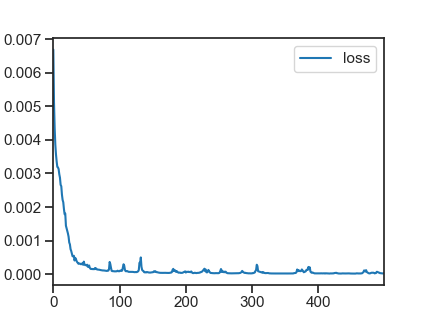

In [272]:
#delete before retraining
try:
    del Balance_Model
except:
    pass
Balance_Model = gb_ann.chemostat_GB_ANN(D,CGlcIn,mean_z,s_z,mean_phi,s_phi,lag_in_model,embed)
ft =  Balance_Model.fit([ze_k_train,st_train],x_train,
                        batch_size=int(N_train/10),
                       epochs=500,
                        verbose=0,
                       )
pd.DataFrame(ft.history).plot() 


In [173]:
# compare with black box model

bb_in = tf.keras.Input(shape=(embed*n_var,))
selector = cl.column_selector_layer(lag_in_model,embed,n_var)
selected = selector(bb_in)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(selected)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
bb_next = tf.keras.layers.Dense(4)(h)


<IPython.core.display.Javascript object>


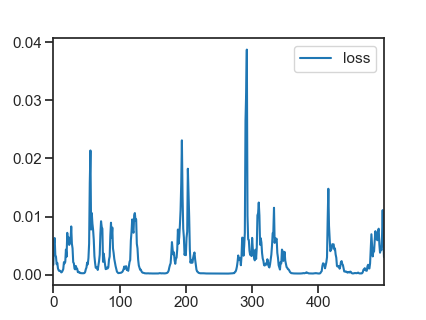

In [210]:


# delete before retraining
try:
    del BlackBox
except:
    pass 
BlackBox = tf.keras.Model(inputs=bb_in,outputs=bb_next)
BlackBox.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),loss=tf.losses.mean_squared_error)
ft_bb =  BlackBox.fit(ze_k_train,x_train,
                        batch_size=int(N_train/10),
                        epochs=500,
                        verbose=0,
                        #validation_data = (ze_k_valid, x_valid)
                        )
pd.DataFrame(ft_bb.history).plot() 

In [273]:
print(Balance_Model.chemostat_GB_ANN_model.evaluate([ze_k_valid,st_valid], x_valid))
print(BlackBox.evaluate(ze_k_valid,x_valid))

43/43 [==============================] - 1s 33ms/step
0.00025081070391883036
43/43 [==============================] - 0s 3ms/step
0.02727125446299204


In [274]:
# Integrate the Model

history0 = tf.reshape(tf.to_float(ze_k[0,n_var::]),[1,embed*n_var-n_var])
xk0      = tf.reshape(tf.to_float(xs_k[0]),[1,4])
uk0      = tf.reshape(tf.to_float(us_k[0]),[1,1])

xkmodel = np.zeros([len(points),4])
history = np.zeros([len(points),embed*n_var-n_var])
xkmodel[0,:] = xk0
history[0,:] = history0

xkbbmodel = xkmodel.copy()
historybb = history.copy()
for i in range(len(points)):
    if i > 0:
        (xkmodel[i,:], history[i,:]) = Balance_Model.step(us_k[i-1],xkmodel[i-1],history[i-1])
        zek_bb = tf.reshape(tf.concat([tf.to_float(us_k[i-1]),
                           tf.to_float(xkbbmodel[i-1]),
                           tf.to_float(historybb[i-1])],axis=0),[1,n_var*embed])
        xkbbmodel[i,:] = BlackBox(zek_bb)
        historybb[i] = zek_bb[:,0:embed*n_var-n_var]
phi_model = Balance_Model.constitutive_law(us_k,xkmodel,history)                                            

In [275]:
print(np.mean((xkmodel[N_train::]-xs_k[N_train::])**2),
      np.mean((xkbbmodel[N_train::]-xs_k[N_train::])**2))

0.13409835341321644 0.966797540011777


<IPython.core.display.Javascript object>


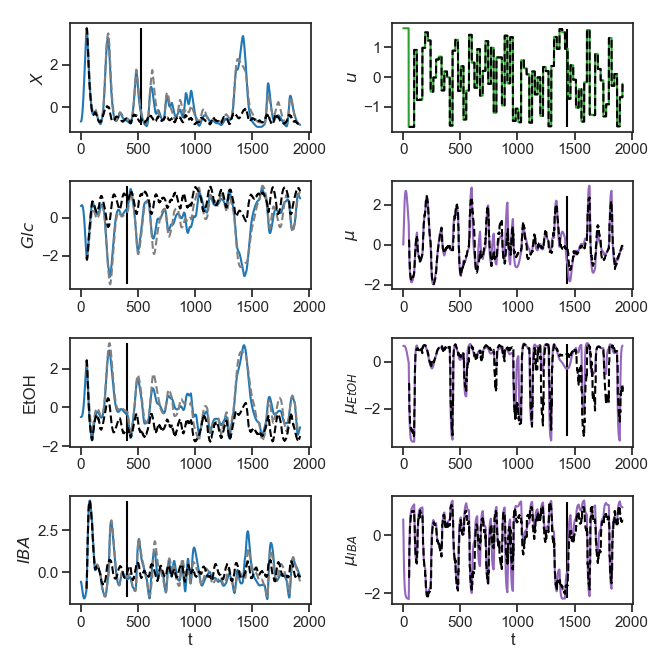

<IPython.core.display.Javascript object>


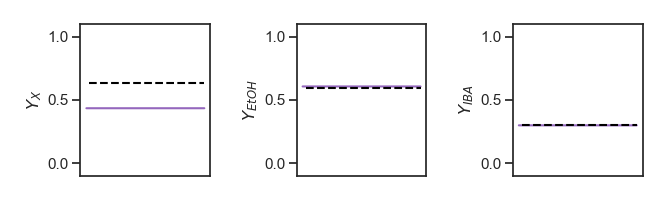

In [276]:
N_points = len(points)
#sns.set_context('talk')
plt.figure(figsize=(10,10))
plt.subplot(421)
plt.plot(t_sim,(x_on[:,0]-mean_x[0])/s_x[0],c=blue)
plt.plot(t_sim[points],xkmodel[:,0],'--',c='grey')
plt.plot(t_sim[points],xkbbmodel[:,0],'--',c='black')
plt.vlines(N_train+30,np.min(xkmodel[:,0]),np.max(xkmodel[:,0]))
plt.ylabel(r'$X$')
plt.subplot(423)
plt.plot(t_sim,(x_on[:,1]-mean_x[1])/s_x[1],c=blue)
plt.plot(t_sim[points],xkmodel[:,1],'--',c='grey')
plt.plot(t_sim[points],xkbbmodel[:,1],'--',c='black')
plt.vlines(.75*N_train+30,np.min(xkmodel[:,1]),np.max(xkmodel[:,1]))
plt.ylabel(r'$Glc$')
plt.subplot(425)
plt.plot(t_sim,(x_on[:,2]-mean_x[2])/s_x[2],c=blue)
plt.plot(t_sim[points],xkmodel[:,2],'--',c='grey')
plt.plot(t_sim[points],xkbbmodel[:,2],'--',c='black')
plt.vlines(.75*N_train+30,np.min(xkmodel[:,2]),np.max(xkmodel[:,2]))
plt.ylabel(r'EtOH')
plt.subplot(427)
plt.plot(t_sim,(x_on[:,3]-mean_x[3])/s_x[3],c=blue)
plt.plot(t_sim[points],xkmodel[:,3],'--',c='grey')
plt.plot(t_sim[points],xkbbmodel[:,3],'--',c='black')
plt.vlines(.75*N_train+30,np.min(xkmodel[:,3]),np.max(xkmodel[:,3]))
plt.ylabel(r'$IBA$')
plt.xlabel(r't')

plt.subplot(422)
plt.plot(t_sim,(u_on-mean_u)/s_u,c=red)
plt.plot(t_sim[points],us_k[:,0],'--',c='k')
plt.vlines(.75*N_points+30,np.min(us_k),np.max(us_k))
plt.ylabel(r'$u$')
plt.subplot(424)
plt.plot(t_sim,(phi_on[:,0]-mean_phi[0])/s_phi[0],c=yellow)
plt.plot(t_sim[points],phi_model[:,0],'--',c='k')
plt.vlines(.75*N_points+30,np.min(phi_model[:,0]),np.max(phi_model[:,0]))
plt.ylabel(r'$\mu$')
plt.subplot(426)
plt.plot(t_sim,(phi_on[:,1]-mean_phi[1])/s_phi[1],c=yellow)
plt.plot(t_sim[points],phi_model[:,1],'--',c='k')
plt.vlines(.75*N_points+30,np.min(phi_model[:,1]),np.max(phi_model[:,1]))
plt.ylabel(r'$\mu_{EtOH}$')
plt.subplot(428)
plt.plot(t_sim,(phi_on[:,2]-mean_phi[2])/s_phi[2],c=yellow)
plt.plot(t_sim[points],phi_model[:,2],'--',c='k')
plt.vlines(.75*N_points+30,np.min(phi_model[:,2]),np.max(phi_model[:,2]))
plt.ylabel(r'$\mu_{IBA}$')
plt.xlabel(r't')
plt.tight_layout()

#plt.savefig('chemo_fit.svg')
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.plot(t_sim,phi_on[:,3],c=yellow)
plt.plot(t_sim[points[[0,-1]]],
         np.array([Balance_Model.chemostat.YGlcX.numpy(),Balance_Model.chemostat.YGlcX.numpy()]),
         '--',c='k')
plt.ylim([-.1,1.1])
plt.xticks([])
plt.ylabel(r'$Y_X$')

plt.subplot(1,3,2)
plt.plot(t_sim,phi_on[:,4],c=yellow)
plt.plot(t_sim[points[[0,-1]]],
         np.array([Balance_Model.chemostat.YGlcEtOH.numpy(),Balance_Model.chemostat.YGlcEtOH.numpy()]),
         '--',c='k')
plt.ylim([-.1,1.1])
plt.xticks([])
plt.ylabel(r'$Y_{EtOH}$')

plt.subplot(1,3,3)
plt.plot(t_sim,phi_on[:,5],c=yellow)
plt.plot(t_sim[points[[0,-1]]],
         np.array([Balance_Model.chemostat.YGlcIBA.numpy(),Balance_Model.chemostat.YGlcIBA.numpy()]),
         '--',c='k')
plt.ylim([-.1,1.1])
plt.xticks([])
plt.ylabel(r'$Y_{IBA}$')
plt.tight_layout()
#plt.savefig('yields_fit.svg')



<IPython.core.display.Javascript object>


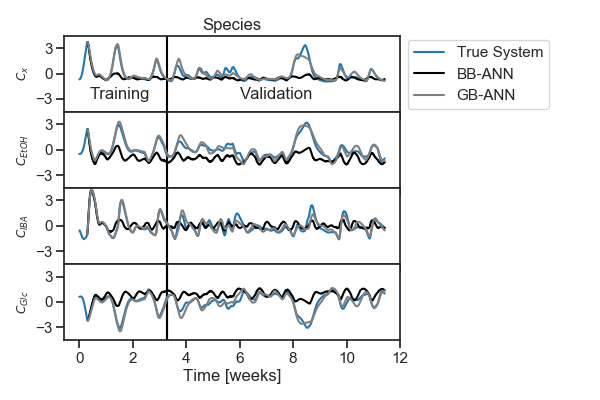

In [385]:
sns.set_context('talk')
width=9
height=6
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, sharey=True,figsize=(width,height))
ax1.vlines((N_train+50)/24/7,-10,10)
ax2.vlines((N_train+50)/24/7,-10,10)
ax3.vlines((N_train+50)/24/7,-10,10)
ax4.vlines((N_train+50)/24/7,-10,10)

ax1.set_title('Species')
ax1.plot(t_sim/24/7,xfs_k.T[0],c=blue,label='True System')
ax1.plot(t_sim[points]/24/7,xkbbmodel.T[0],c='k', label='BB-ANN')
ax1.plot(t_sim[points]/24/7,xkmodel.T[0],c='grey', label='GB-ANN')
ax1.set_ylim(-4.5,4.5)
ax1.set_yticks([-3,0,3])
ax1.set_ylabel(r'$C_x$',fontsize=13)

ax4.plot(t_sim/24/7,xfs_k.T[1],c=blue)
ax4.plot(t_sim[points]/24/7,xkbbmodel.T[1],c='k')
ax4.plot(t_sim[points]/24/7,xkmodel.T[1],c='grey')
ax4.set_ylim(-4.5,4.5)
ax4.set_yticks([-3,0,3])
ax4.set_ylabel(r'$C_{Glc}$',fontsize=13)
ax1.text(.4,-3,'Training')
ax1.text(6,-3,'Validation')


ax2.plot(t_sim/24/7,xfs_k.T[2],c=blue)
ax2.plot(t_sim[points]/24/7,xkbbmodel.T[2],c='k')
ax2.plot(t_sim[points]/24/7,xkmodel.T[2],c='grey')
ax2.set_ylim(-4.5,4.5)
ax2.set_yticks([-3,0,3])
ax2.set_ylabel(r'$C_{EtOH}$',fontsize=13)

ax3.plot(t_sim/24/7,xfs_k.T[3],c=blue)
ax3.plot(t_sim[points]/24/7,xkbbmodel.T[3],c='k')
ax3.plot(t_sim[points]/24/7,xkmodel.T[3],c='grey')
ax3.set_ylim(-4.5,4.5)
ax3.set_yticks([-3,0,3])
ax3.set_ylabel(r'$C_{IBA}$',fontsize=13)


ax4.set_xlabel('Time [weeks]')
#plt.ylim(-3.5,3.5)


plt.tight_layout()
ax1.legend(bbox_to_anchor=(1, 1.042))
fig.subplots_adjust(hspace=0,bottom=.15,right=height/width)

#plt.savefig('../figs/chemostat_error_talk.svg')

In [378]:
model_yields = np.array([Balance_Model.chemostat.YGlcX,
                         Balance_Model.chemostat.YGlcEtOH,
                         Balance_Model.chemostat.YGlcIBA])
true_yields = np.array([YGlcX, YGlcEtOH, YGlcIBA])
labels=[r'$Y_X$', r'$Y_{EtOH}$', r'$Y_{IBA}$']
bar_inds = np.arange(3)
bar_width = 0.35

<IPython.core.display.Javascript object>


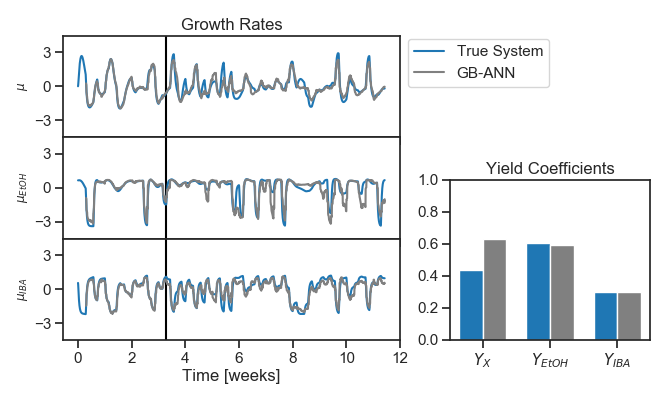

In [386]:
D

<IPython.core.display.Javascript object>


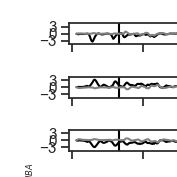

In [358]:
sns.set_context('talk')
fig = p


plt.tight_layout()
#fig.subplots_adjust(hspace=0,bottom=.15)
#plt.savefig('../figs/chemostat_error_paper.svg')